In [1]:
from __future__ import division, print_function
import sys

# Freezing emulsions  - particle dynamics

Welcome to this notebook ! The code below has been developed to analyse the confocal images obtained during the freezing of emulsions. The results have been reported in the following paper:
"5D imaging of freezing emulsions with solute effects", by Dmytro Dedovets, Cécile Monteux,and Sylvain Deville, and published in Science in 2018.

If you want to use this code and the data we provided, you should organise your files as follows. Create a main directory with 2 subdirectory:
- "code": put the notebooks here. Create a folder inside called "functions". In this functions folder, you need to put the detect peak script which you can find here http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
- "data": put the data here

When you start the notebook, another directory ("Results") will be created, and all the csv files and figures generated will be saved there.


Feedback is welcome, keep in touch with us if you want to discuss anything,

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
#from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6)) # defaut figure size
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims # to read the image stack
import trackpy as tp # for particle tracking
import time
import skimage as sk

from IPython import display
from IPython.display import clear_output
from IPython.display import display
import ipywidgets as widgets # used for the progress bar


In [3]:
import random
from scipy import ndimage
from skimage import morphology, util, filters, exposure
from scipy import misc
from os import walk  		# needed to list all files in directory
from os import path 		# needed to save file
from os import makedirs
from os import remove
from os import path 		# needed to save file
import os
import shutil # to deal with directories
import fnmatch

# sample references

In [4]:
samples_conditions = pd.DataFrame(columns=['velocity', 'spf', 'sample_file'])

samples_conditions.loc[0] = [1,13.77,'DD17.026B(1mkm-sec)Series007']
samples_conditions.loc[1] = [2,6.853,'DD17.026A(2mkm-sec)Series004']
samples_conditions.loc[2] = [3,5.140,'DD17.026C(3mkm-sec)Series003']
samples_conditions.loc[3] = [4,3.433,'DD17.027B(4mkm-sec)Series005']
samples_conditions.loc[4] = [5,3.433,'DD17.026D(5mkm-sec)']
samples_conditions.loc[5] = [6,1.717,'DD17.026I(6mkm-sec)Series003']
samples_conditions.loc[6] = [8,1.717,'DD17.026H(8mkm-sec)']
samples_conditions.loc[7] = [10,1.717,'DD17.026F(10mkm-sec)']

In [5]:
samples_conditions.loc[13] = [5,19.027,'ST18.002(10c-mm,5mkm-sec,+5,-5)Series004']

samples_conditions.loc[14] = [10,1.717,'ST18.003(10c-mm,10mkm-sec,+5,-5)Series005']

samples_conditions.loc[15] = [1,1.717,'ST18.005(10c-mm,1mkm-sec,+10,-10)Series001']
samples_conditions.loc[20] = [5,1.717,'ST18.005(10c-mm,5mkm-sec,+10,-10)Series002']

samples_conditions.loc[16] = [3,1.717,'ST18.008(10c-mm,3mkm-sec,+10,-10)Series001']
samples_conditions.loc[17] = [5,1.717,'ST18.008(10c-mm,5mkm-sec,+10,-10)Series002']
samples_conditions.loc[18] = [1,1.717,'ST18.008(10c-mm,1mkm-sec,+10,-10)Series003']
samples_conditions.loc[19] = [10,1.717,'ST18.008(10c-mm,10mkm-sec,+10,-10)Series004']



samples_conditions.loc[21] = [4,1.717,'ST18.009(10c-mm,4mkm-sec,+10,-10)Series002']
samples_conditions.loc[22] = [6,1.717,'ST18.009(10c-mm,6mkm-sec,+10,-10)Series003']
samples_conditions.loc[23] = [8,1.717,'ST18.009(10c-mm,8mkm-sec,+10,-10)Series004']


In [6]:
samples_conditions.loc[24] = [5,1.717,'ST18.010(10c-mm,5mkm-sec,+10,-10)Series001']
samples_conditions.loc[25] = [10,1.717,'ST18.010(10c-mm,10mkm-sec,+10,-10)Series002']
samples_conditions.loc[26] = [15,1.717,'ST18.010(10c-mm,15mkm-sec,+10,-10)Series003']
samples_conditions.loc[27] = [20,1.717,'ST18.010(10c-mm,20mkm-sec,+10,-10)Series004']

samples_conditions.loc[28] = [3,1.717,'ST18.013(10c-mm,3mkm-sec,+10,-10)Series001']
samples_conditions.loc[29] = [8,1.717,'ST18.013(10c-mm,8mkm-sec,+10,-10)Series002']
samples_conditions.loc[30] = [12,1.717,'ST18.013(10c-mm,12mkm-sec,+10,-10)Series003']

samples_conditions.loc[31] = [5,1.717,'ST18.014(10c-mm,5mkm-sec,+10,-10)Series001']
samples_conditions.loc[32] = [10,1.717,'ST18.014(10c-mm,10mkm-sec,+10,-10)Series002']
samples_conditions.loc[33] = [15,1.717,'ST18.014(10c-mm,15mkm-sec,+10,-10)Series003']


In [7]:
samples_conditions.loc[34] = [1,1.717,'ST18.015(10c-mm,1mkm-sec,+10,-10)Series001']
samples_conditions.loc[35] = [5,1.717,'ST18.015(10c-mm,5mkm-sec,+10,-10)Series001']
samples_conditions.loc[36] = [10,1.717,'ST18.015(10c-mm,10mkm-sec,+10,-10)Series001']

In [8]:
samples_conditions.loc[37] = [3,1.717,'ST18.020(10c-mm,3mkm-sec,+10,-10)Series003']
samples_conditions.loc[38] = [10,1.717,'ST18.021(10c-mm,10mkm-sec,+14,-6)Series001']

In [9]:
samples_conditions

,velocity,spf,sample_file
0,1,13.770,DD17.026B(1mkm-sec)Series007
1,2,6.853,DD17.026A(2mkm-sec)Series004
2,3,5.140,DD17.026C(3mkm-sec)Series003
3,4,3.433,DD17.027B(4mkm-sec)Series005
4,5,3.433,DD17.026D(5mkm-sec)
5,6,1.717,DD17.026I(6mkm-sec)Series003
6,8,1.717,DD17.026H(8mkm-sec)
7,10,1.717,DD17.026F(10mkm-sec)
13,5,19.027,"ST18.002(10c-mm,5mkm-sec,+5,-5)Series004"
14,10,1.717,"ST18.003(10c-mm,10mkm-sec,+5,-5)Series005"


In [10]:
# MY space scale
space_scale = 1551.5152/1024.0 # microns/pixel

# Minimum track length
min_track_length = 40

# Figure file type
fig_file_type = '.png'

In [10]:
# Space scale
space_scale = 775.0/1024.0 # microns/pixel. The same for all the data in our study

# Minimum track length. Minimum number of points in a trajectory. 
# This eliminates (later in the code) the trajectories that are too short
min_track_length = 40 

# Figure file type
fig_file_type = '.png'

In [11]:
# input here the reference of the sequence you want to analyse
sample_to_analyse = 24

# read the corresponding line
sample = samples_conditions.sample_file.loc[sample_to_analyse]

# read the time frequency from samples_conditions
spf = samples_conditions.spf.loc[sample_to_analyse] # seconds per frame
# Time scale
fps = 1/spf

# read the sample velocity from samples_conditions 
sample_velocity = samples_conditions.velocity.loc[sample_to_analyse] # in microns per sec


# Organisation of the notebook
The notebook is made of two main parts. The first one read the solute channel to detect the interface position. Because we have small fluctuations of the interface position, we determine the interface position in each frame. This is used in the second part of the notebook to measure the distance between a given droplet and the interface

# Track the interface position

## Function to detect peak position

In [12]:
#%load functions/detect_peaks.py
# uncomment the first line of the cell when you run the notebook for the first time

"""Detect peaks in data based on their amplitude and other features."""

#from __future__ import division, print_function
#import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

## Load the solute channels

Frame([[ 6,  6,  7, ...,  4,  3,  4],
       [ 9,  8,  8, ...,  3,  4,  3],
       [ 8,  9,  5, ...,  3,  3,  3],
       ...,
       [ 7,  9, 11, ...,  3,  3,  3],
       [ 7,  7,  7, ...,  3,  3,  4],
       [10,  9,  8, ...,  3,  4,  4]], dtype=uint8)
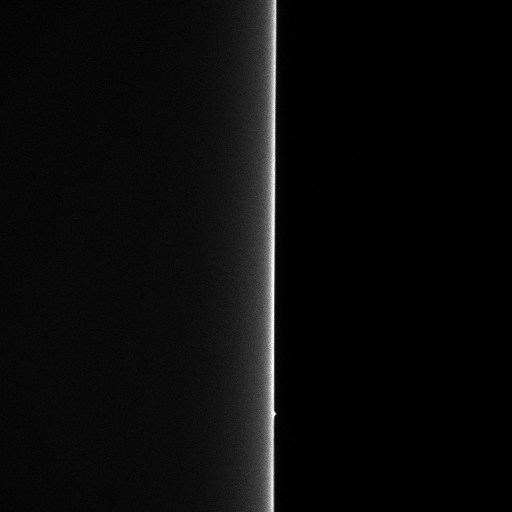

In [14]:
filename = 'Z:/PhD/Experiments & Results/Data Complete/data/'+ sample + '-solute.tif'
frames_solute = pims.TiffStack_pil(filename)
frames_solute[99]
# The x-axis is horizontal, the y-axis vertical (see Fig. 1b of the paper)

In [15]:
# Function used for smooting the intensity profile and remove the noise due to the heterogeneities
# in the solidification microstructure (e.g. grain boundaries)
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

## Functions to detect the position of the interface
We tested several routines to detect the position of the interface from the intensity profile. We always start by averaging the fluorescence intensity along the y-axis. We then use this profile to determine the position of the front.

The shape of this profile depends on the morphology of the front (crystal tip). This is particularly true for the lowest interface velocity (1 micron/s). We choose to use always the same function (detect_interface_position_slope) to determine the interface position to be consistent. 

In [16]:
def detect_interface_position_slope(image):
    '''
    Detect the position of the interface by summing the intensity along the direction
    parallel to the interface, and then looking for the maximum of the derivative of 
    intensity value. This is possible because rhodamine is segregated by the front and
    the concentration of rhodamine is the highest close to the freeze front
    
    The interface position here is the position of the sharpest gradient of intensity
    '''
    image = np.average(image, axis=0) # sum all values along the row
    smoothed = smooth(image, 10)
    #average_image = moving_average(image, 20) # smooth the profile to eliminate noise
    slope = np.diff(smoothed) # make the derivative
    # because the interface is always more or less in the center of the image, we remove the 
    # first and last 200 pixels. This reduces the risk of false positives.
    interface_position = np.argmin(slope[400:800]) # get the value of the gradient is the sharpest
    
    return (interface_position+400, image)


## Another way to detect interface position
This function gives a better results for the 1 micron/s sequence (because the morphology of the front is different from that of the other sequences).

In [ ]:
def detect_interface_position_valley(image):
    '''First smooth the average intensity
    Then detect peaks in the average profile
    Looks at the valley between two peaks
    Takes the valley peak value if it exists, otherwise takes the peak value if only one peak, '''
    average = np.average(image, axis=0) # sum all values along the row
    smoothed = smooth(average, 10)
    ind = detect_peaks(smoothed,show=False, mph=45, mpd=10, edge='both');
    
    if  len(ind)<2: #if just one peak
        local_min = ind[0] 
    else: # it two peaks, look for valley between the peaks
        windows = average[ind[0]:ind[1]]
        ind_valley = detect_peaks(windows,show=False, mph=-50, mpd=10, valley=True)
        local_min = ind[0] + ind_valley[-1]

    return (local_min, average)

## Test the interface detection routine
Use this frame to test the interface detection routine. The output shows the frame chosen by the slider. The yellow line is the average intensity along the frame. The vertical red line indicates the position of the interface that was determined.

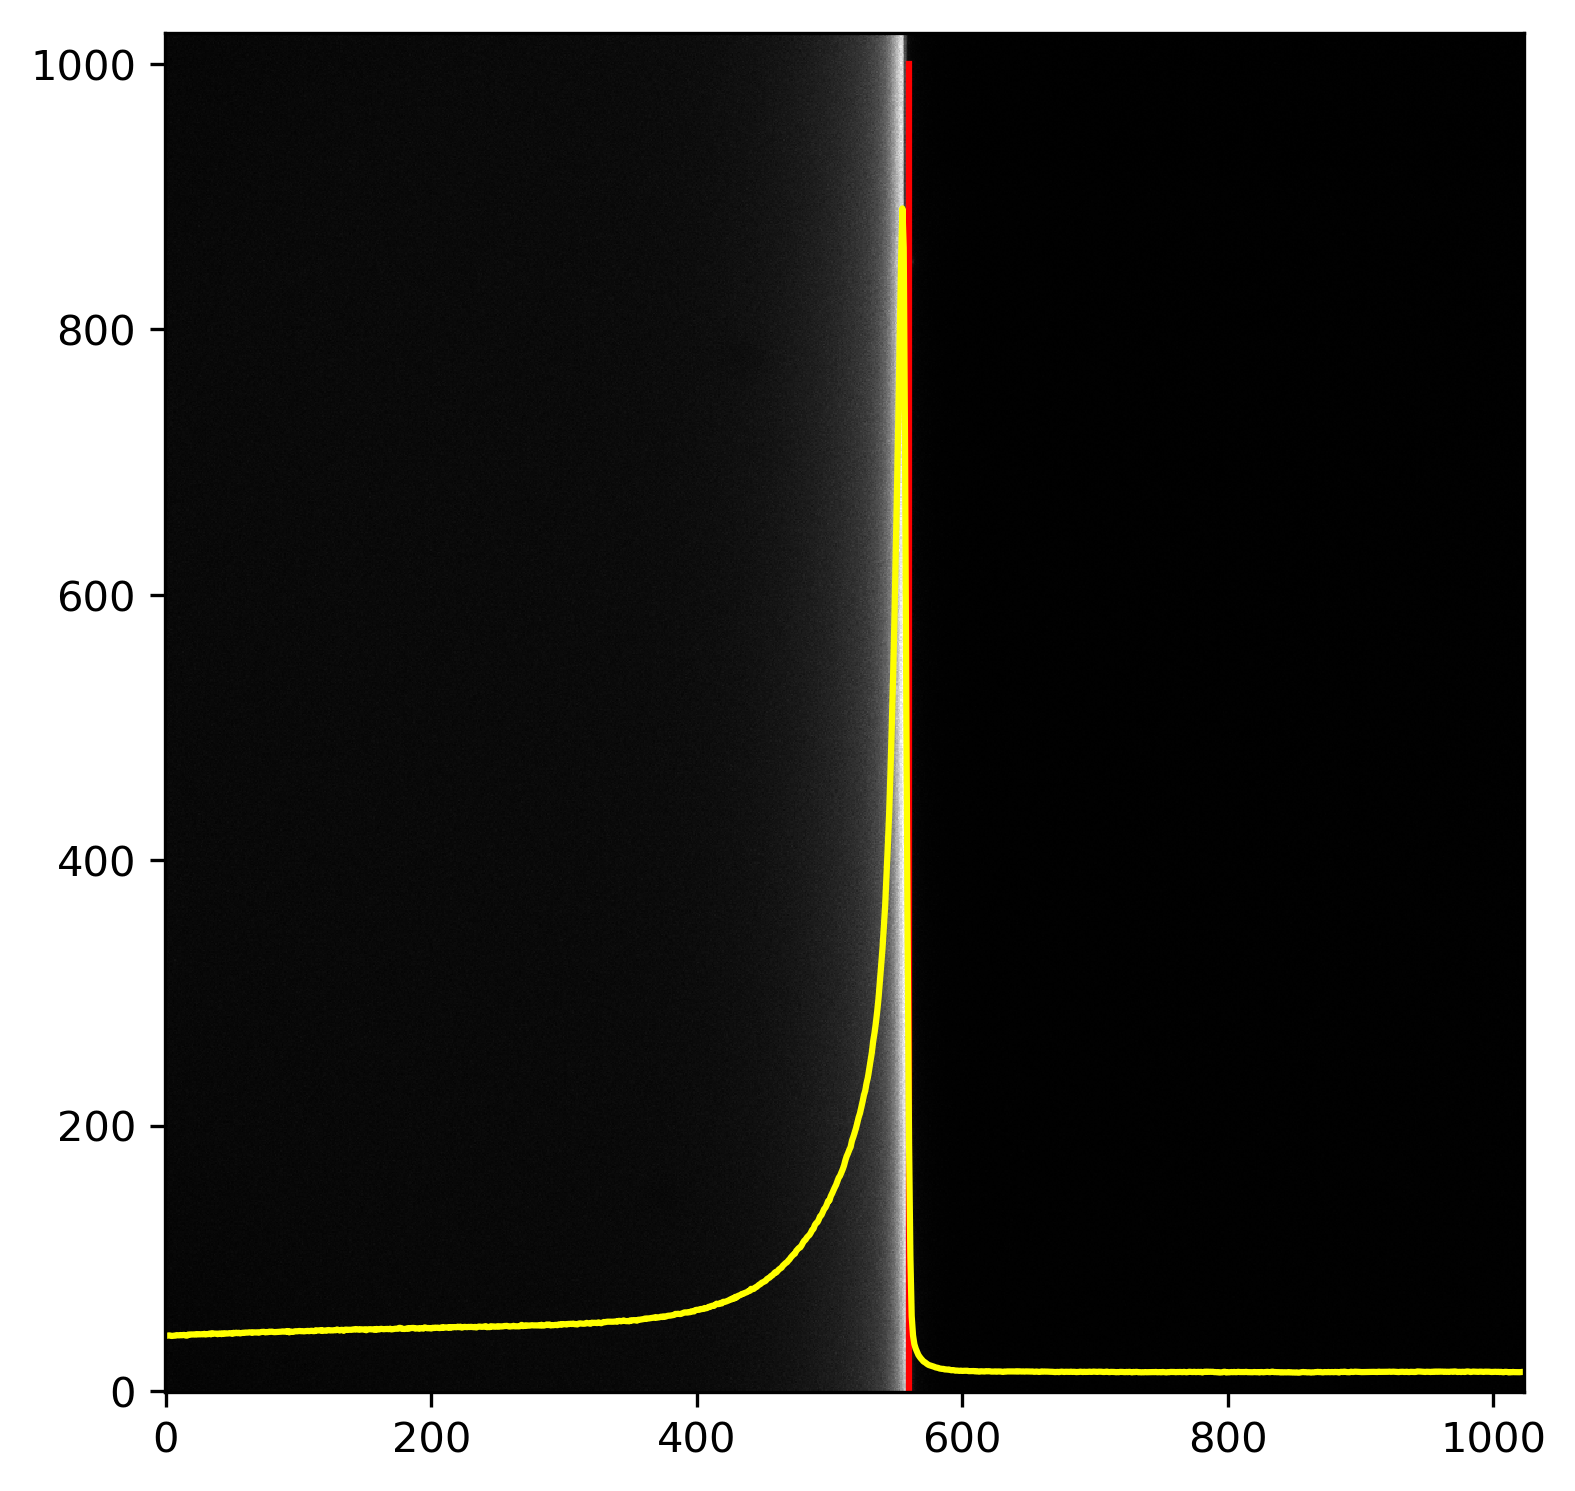

In [17]:
def on_value_change(change):
    '''
    Takes the int value from the slider and use it to select the corresponding frame.
    Detect the interface position, and overlay it with the frame image.
    '''
    clear_output()
    image = frames_solute[int_range.value]
    threshold, result_image = detect_interface_position_slope(image)
    fig = plt.figure(figsize=(6,6), dpi=300)
    plt.imshow(frames_solute[int_range.value], origin='lower'); # show the original image
    plt.plot((threshold,threshold),(0,1000), 'r-') # draw the interface line
    x = np.arange(len(image))
    # plot the summed intensity profile along the y axis
    plt.plot(x, result_image*4, color='yellow')

int_range = widgets.IntSlider(value=0, min=0, max=len(frames_solute)-1, description='Frame number')
display(int_range)

int_range.observe(on_value_change, names='value');

## Apply the interface detection routine to the entire sequence

In [18]:
position_interface = []
f = widgets.FloatProgress(min=0, max=len(frames_solute))
display (f)

for image in frames_solute:
    # choose the interface detection function in the line below
    threshold, result_image = detect_interface_position_slope(image)
    position_interface.append(threshold)
    f.value +=1 # animate the progress bar

A Jupyter Widget

## Convert from pixels to microns and frame to seconds

In [19]:
position_interface_threshold = np.array(position_interface)
# remove the last point. The last frame is always interrupted during the acquisition of the sequence
position_interface_threshold = position_interface_threshold[:-1]
position_interface_threshold = [value*space_scale for value in position_interface_threshold] # pixel>micron conversion
position_interface_time = range(len(position_interface_threshold))
position_interface_time = [value*spf for value in position_interface_time] # frame>second conversion

## Compute the average position of the interface, using the moving average

In [20]:
average_position = smooth(position_interface_threshold, 10) # average and conversion in seconds
for i in range(5):
    average_position[-i] = position_interface_threshold[-i]
    average_position[i] = position_interface_threshold[i]

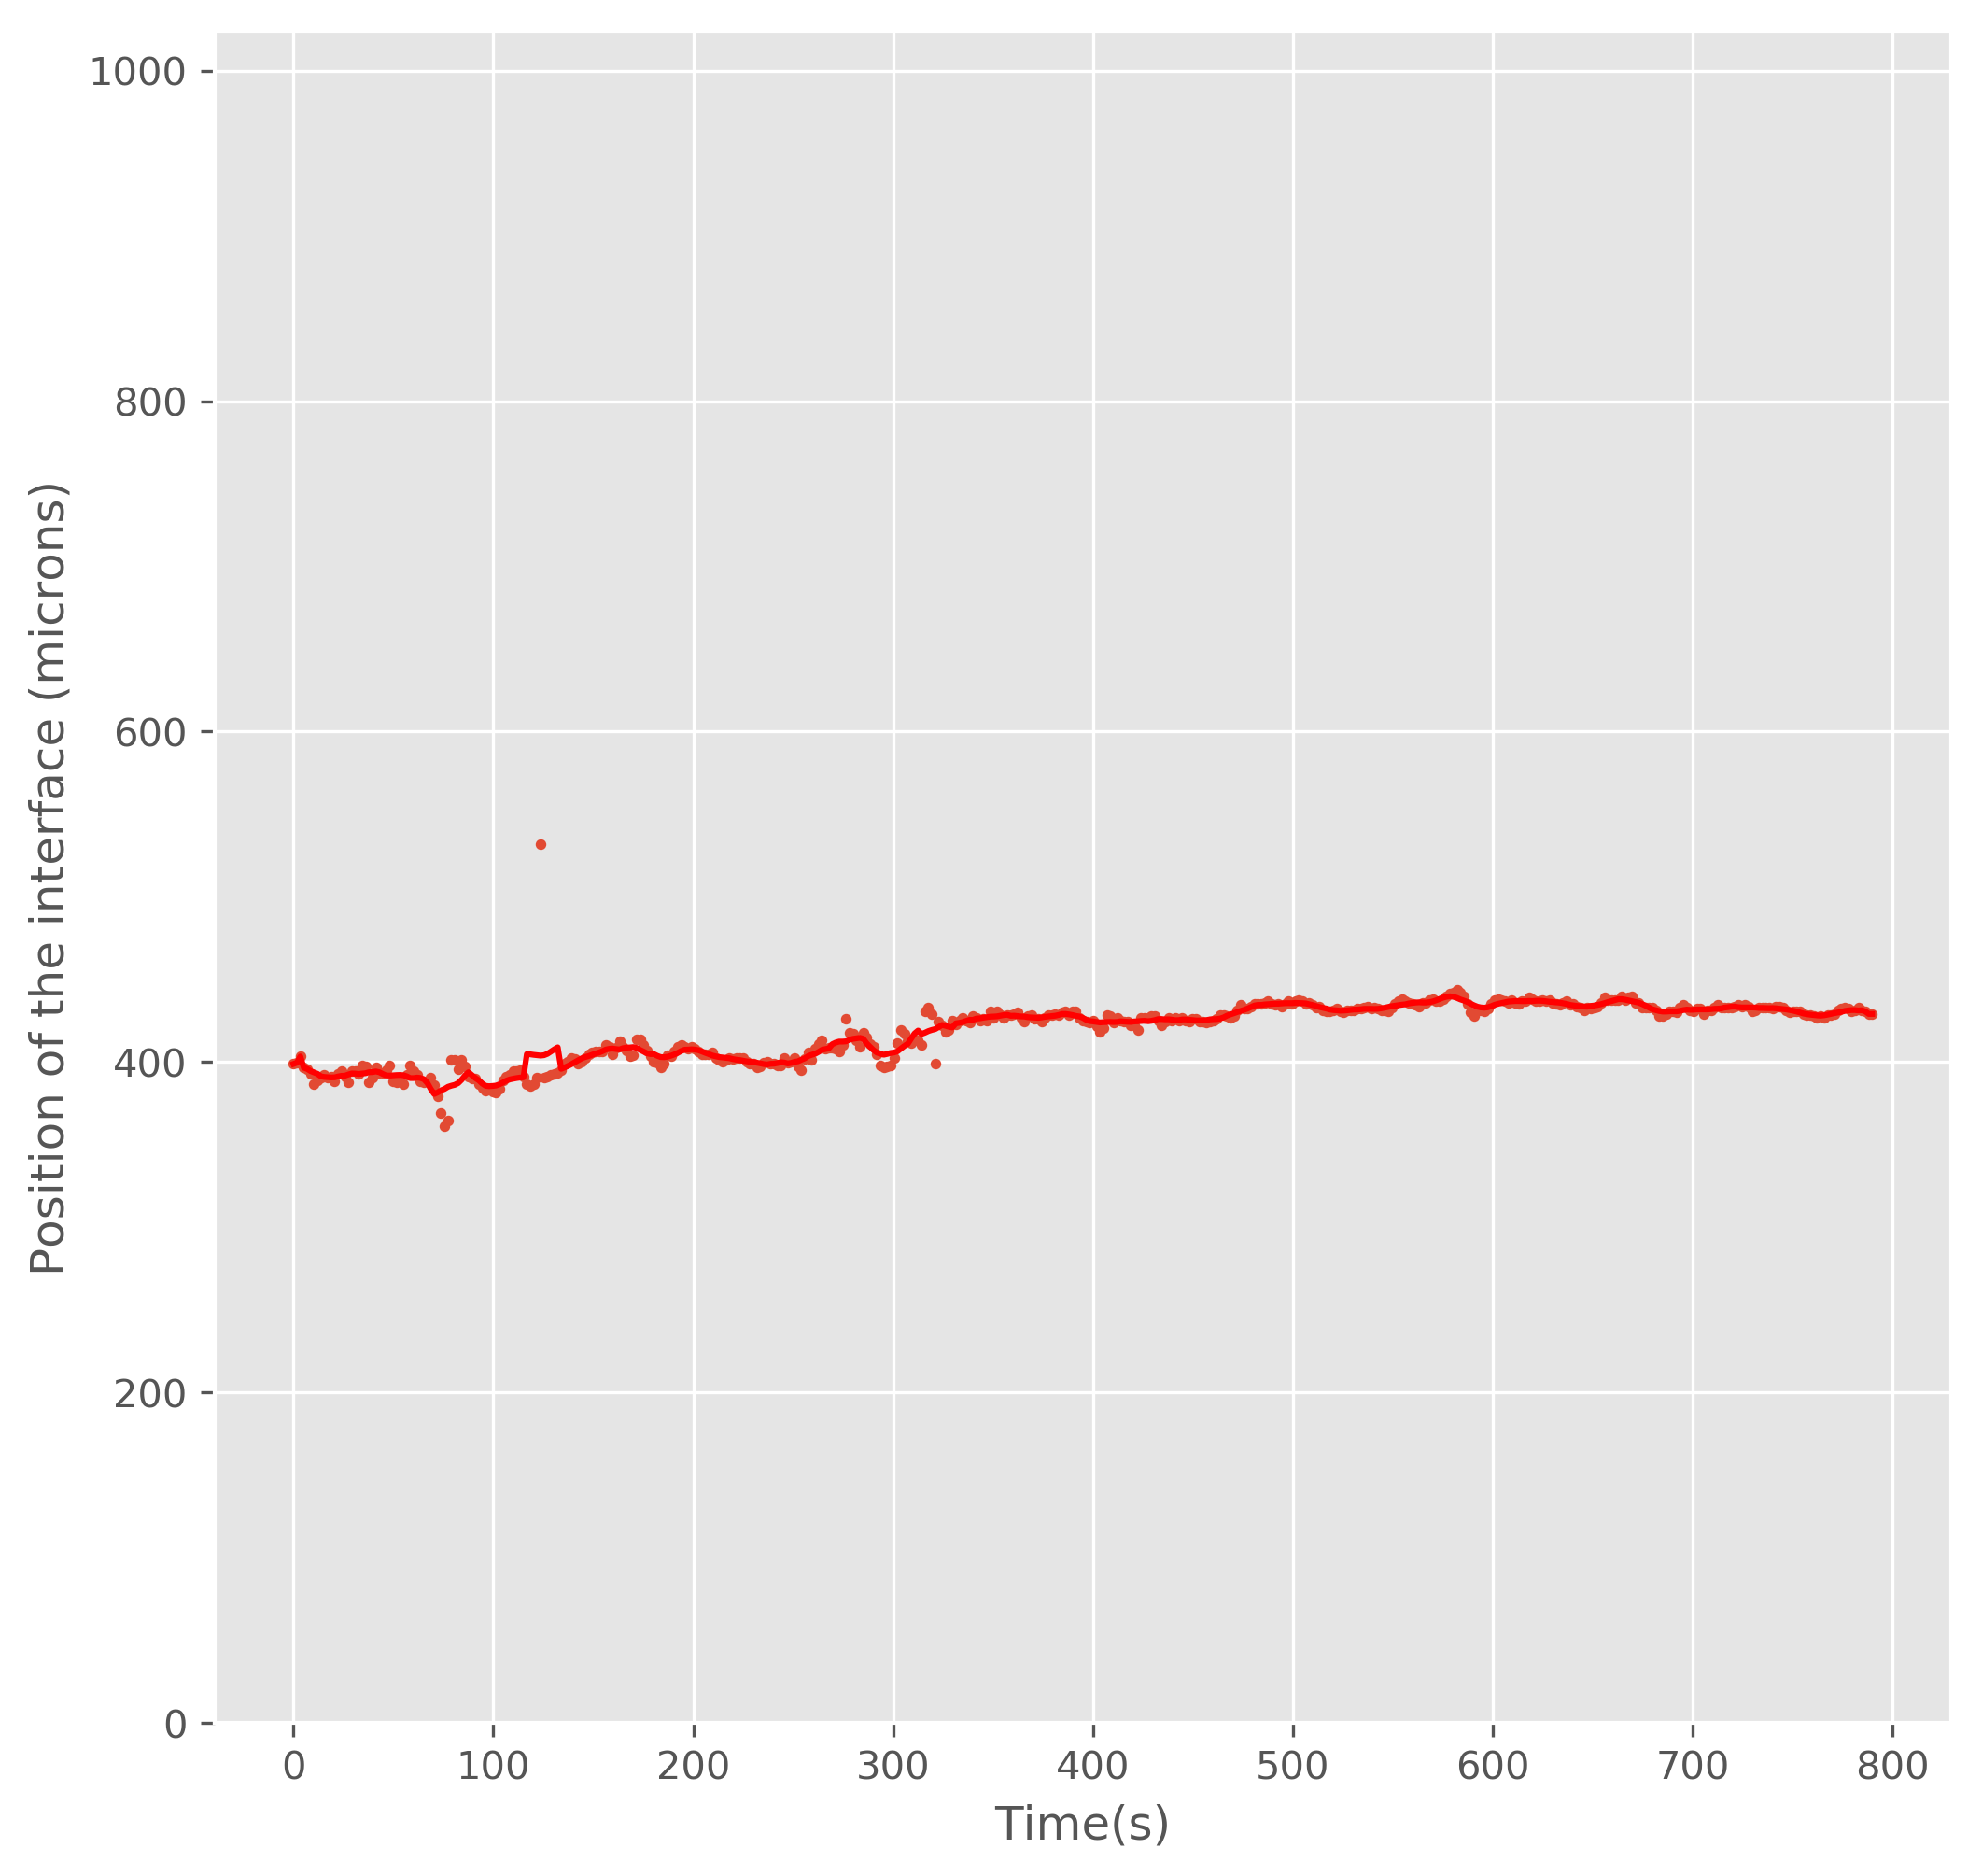

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8), dpi=300)
x = np.arange(len(position_interface_threshold))*spf # conversion from frames to seconds
plt.scatter(x, position_interface_threshold, s=5)
plt.plot(x, average_position, '-r')
plt.xlabel('Time(s)')
plt.ylim(0,1024)
plt.ylabel('Position of the interface (microns)')

interface_plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/data/' + sample + fig_file_type
plt.savefig(interface_plot_filename, dpi=600)
plt.show()

## Save the interface position results

In [22]:
interface_position_dataframe = pd.DataFrame(columns=['x','interface_position', 'averaged_position']) 
       
for i in range (len(x)):
    interface_position_dataframe.loc[i] = (x[i], position_interface_threshold[i], average_position[i])

interfaceposition_filename = 'Z:/PhD/Experiments & Results/Data Complete/data/' + sample + ".csv"
interface_position_dataframe.to_csv(interfaceposition_filename)

# Compute, average and save the concentration profile
The dectected position of the interface is used to center all the intensity profile on the interface position.

In [23]:
f = widgets.FloatProgress(min=0, max=len(frames_solute))
display (f)
   
# Create an empty dataframe to save the concentration profile results
concentration_profile = pd.DataFrame(columns=['x_abs','intensity', 'norm_intensity']) 

for i, image in enumerate(frames_solute[:-1]):
    average = np.average(image, axis=0)
    # we can normalize the values either on the fluorescence intensity at the extremity of the frame (in the liquid), 
    norm_average = average/np.mean(average[0:20])
    # or using the max intensity in the frame
    #norm_average = average/np.max(average)
    position = np.linspace(1,1024,1024)
    position_microns = position * space_scale
    distance_to_interface = np.linspace(1,1024,1024) * space_scale - average_position[i]
    
    d = {'x_abs': distance_to_interface, 'intensity': average, 'norm_intensity':norm_average}
    df = DataFrame(data=d)
    concentration_profile = concentration_profile.append(df,ignore_index=True)
    
    f.value +=1 # animate the progress bar

A Jupyter Widget

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [24]:
concentration_filename = 'Z:/PhD/Experiments & Results/Data Complete/data/' + sample + '.csv'
concentration_profile.to_csv(concentration_filename)

Text(0,0.5,'Concentration (norm.)')

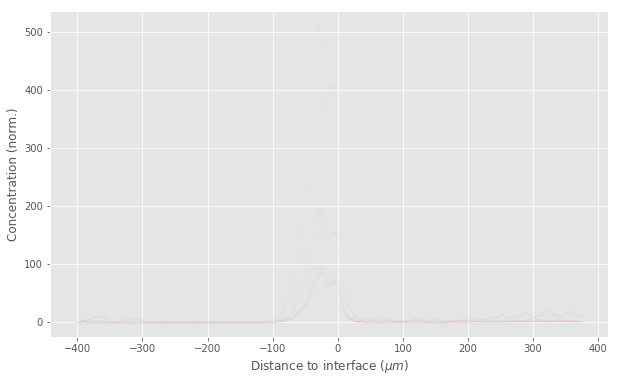

In [25]:
plt.scatter(concentration_profile.x_abs, concentration_profile.norm_intensity, s=5, alpha=0.002)
plt.xlabel(r'Distance to interface ($\mu m$)')
#plt.ylim(0,1.5)
plt.ylabel('Concentration (norm.)')

Text(0,0.5,'Concentration (a.u.)')

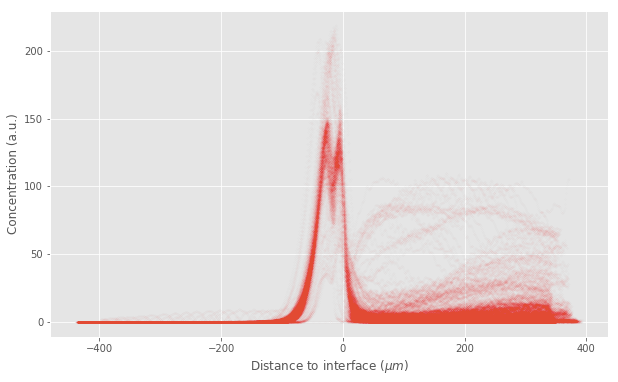

In [26]:
plt.scatter(concentration_profile.x_abs, concentration_profile.intensity, s=5, alpha=0.002)
plt.xlabel(r'Distance to interface ($\mu m$)')
#plt.ylim(0,1.5)
plt.ylabel('Concentration (a.u.)')

***

# Particle tracking and analysis

## Load the particle images
and then display the number of objects found on each frame
The code is slow to run when many objects are found on each frame

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
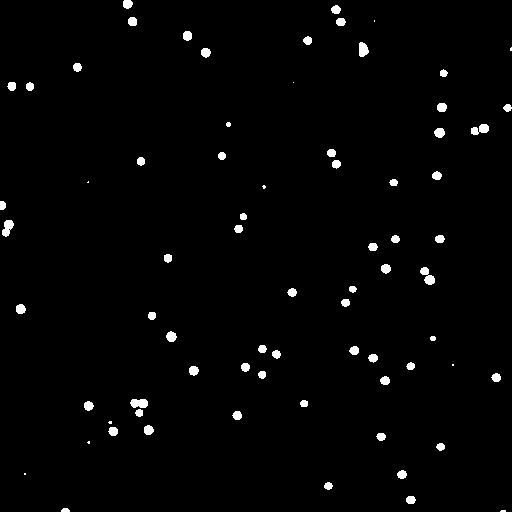

In [27]:
filename = 'Z:/PhD/Experiments & Results/Data Complete/data/'+ sample + '.tif'
images = pims.TiffStack_pil(filename, as_grey=True)
images[150]

In [28]:
label_image = sk.measure.label(images[10])
regions = sk.measure.regionprops(label_image, intensity_image=images[100])

print ('number of objects: ' + str(len(regions)))

number of objects: 81


## Test the particle analysis procedure on a single frame first

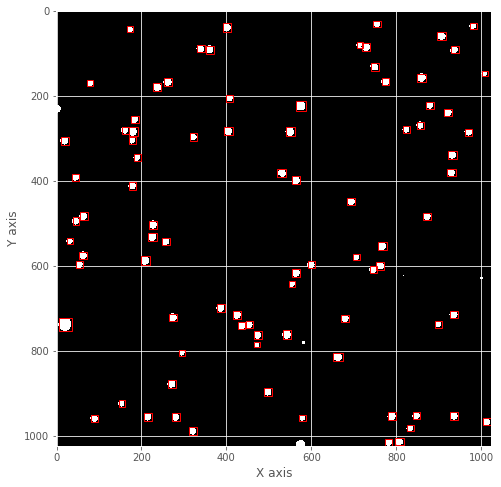

In [29]:
img_example = images[0]
image_dimensions =len(img_example)

# Label elements on the picture
label_image = sk.measure.label(img_example)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
plt.xlabel('X axis')
plt.ylabel('Y axis')
ax.imshow(img_example)
for region in sk.measure.regionprops(label_image, intensity_image=img_example, coordinates='xy'):
    if region.area < 100 or region.area > 800:# Everywhere, skip small and large areas
        continue
    if region.eccentricity>0.8:
        continue
    # exclude the objects that touches the borders
    minr, minc, maxr, maxc = region.bbox
    if minr==0 or minc==0 or maxr==image_dimensions or maxc==image_dimensions:
        continue
    
    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

## Run the analysis on all the frames

In [30]:
features = pd.DataFrame()

# Progress bar using a widget
f = widgets.FloatProgress(min=0, max=len(images))
display (f)

for num, img in enumerate(images):
    label_image = sk.measure.label(img)
    f.value+=1
    for region in sk.measure.regionprops(label_image, intensity_image=img,coordinates='xy'):
        # Everywhere, skip small and large areas
        if region.area < 200 or region.area > 10000:
            continue
        # skip elongated objects, that are segmentation artifacts
        if region.eccentricity>0.8:
            continue
        
        # exclude the objects that touches the borders
        minr, minc, maxr, maxc = region.bbox
    
        if minr==0 or minc==0 or maxr==image_dimensions or maxc==image_dimensions:
            continue
        
        elongation = float(region.major_axis_length)/float(region.minor_axis_length)
        if elongation>3:
            continue
            
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'dx': 0,
                                     'dy': 0,
                                     'frame': num,
                                     'area':region.area,
                                     'equiv_diameter':region.equivalent_diameter,
                                     'norm_diameter':0,
                                     'instant_velocity':0,
                                     'elongation':elongation,
                                     'perimeter':region.perimeter,
                                     'y_relative':0,
                                     'y_relative_edge':0,
                                     'y_edge':minr
                                     },])
    

A Jupyter Widget

## Get the trajectories and plot them

Frame 461: 5 trajectories present


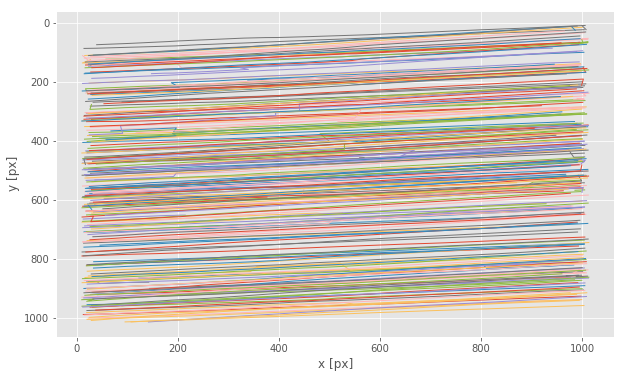

In [31]:
search_range = 35
t = tp.link_df(features, search_range, memory=2)
clean_tracks = tp.filter_stubs(t, min_track_length) # select tracks with more than XX frames
plt.figure()
tp.plot_traj(clean_tracks);

## Unstack, compute velocities, and write the trajectories in a dataframe

In [32]:
data = pd.DataFrame()
# Progress bar using a widget
f = widgets.FloatProgress(min=0, max=len(set(clean_tracks.particle)))
display (f)

for item in set(clean_tracks.particle):
    sub = clean_tracks[clean_tracks.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    diam = sub.equiv_diameter
    # we could remove the small and large diameters here
    for x, y, dx, dy, diam,frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, diam, sub.frame[:-1],):
        data = data.append([{'dx': dx, 
                             'dy': dy, 
                             'x': x,
                             'y': y,
                             'y_relative':0,
                             'y_relative_edge':0,
                             'frame': frame,
                             'particle': item,
                             'diameter': diam,
                            }])
    f.value+=1

A Jupyter Widget

## Functions

In [33]:
def moving_average(a, n):
    '''
    Compute the moving average. n is the period
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]/n

## Collapse all trajectories with the same starting point

In [34]:
save_path = 'Z:/PhD/Experiments & Results/Data Complete/results/plots/'    # where to write the results

if path.exists(save_path):
    shutil.rmtree(save_path)
makedirs(save_path)

#clean_tracks = tp.filter_stubs(data, min_track_length) # select tracks with more than min_track_length frames

# create an empty dataframe to store results
collapsed_position = pd.DataFrame(columns=['track_id',
                                           'x',
                                           'x_abs',
                                           'y',
                                           'diameter',
                                           'x_velocity',
                                           'y_velocity',
                                           'time',
                                           'relative_time']) 
#number_of_particles = int(np.amax(data.particle))

In [35]:
pb = widgets.FloatProgress(min=0, max=len(set(clean_tracks.particle)))
display (pb)

for item in set(clean_tracks.particle):
    sub = t[t.particle==item]
    starting_frame = np.amin(sub.frame) # first frame of the sequence
    starting_x = sub.x.iloc[0] # lowest x value (first x position when particle enters the frame)
    if starting_x < 50: # here we could filter on min and max particle diameter too
        starting_y = sub.y.iloc[0] # first y position of the serie
        
        #dvx = true_particle_velocity - np.diff(sub.x) * space_scale / spf # compute the velocity
        dvx = sample_velocity - np.diff(sub.x) * space_scale / spf # compute the velocity
        dvy = np.diff(sub.y) * space_scale / spf # compute the velocity
        
        for i in range(len(sub)-1):
            gap = average_position[starting_frame+i] - sub.x.iloc[i]*space_scale
            if gap<0:
                break
    
    
        for x, y, equiv_diameter, dx, dy, frame in zip(sub.x[:-1], 
                                                   sub.y[:-1], 
                                                   sub.equiv_diameter[:-1], 
                                                   dvx,
                                                   dvy, 
                                                   sub.frame[:-1]):
            collapsed_position = collapsed_position.append([{'track_id':item,
                                                             'x': x * space_scale, # in microns
                                                             'x_abs':(x+equiv_diameter/2)*space_scale-average_position[starting_frame+i], # in microns
                                                             'y': (y - starting_y) * space_scale, # in microns
                                                             'diameter': equiv_diameter * space_scale, # in microns 
                                                             'x_velocity': dx, # in microns/s
                                                             'y_velocity': dy, # in microns/s
                                                             'time': (frame - starting_frame) * spf,
                                                             'relative_time':(frame - (starting_frame+i)) * spf}]) # in seconds
    pb.value+=1 # update progress bar

# the values in collapsed_position are now seconds, microns

A Jupyter Widget


## Compute the average position at a given time, and the standard deviation

In [36]:
average_pos = pd.DataFrame(columns=['time','x', 'y', 'stdx', 'stdy','expected_position', 'delay']) 

for item in set(collapsed_position.time):
    sub = collapsed_position[collapsed_position.time==item]
    mean_x = np.mean(sub.x)
    mean_y = np.mean(sub.y)
    std_x = np.std(sub.x)
    std_y = np.std(sub.y)
    

    average_pos = average_pos.append([{'time': item,
                                       'x':mean_x,
                                       'y':mean_y,
                                       'stdx':std_x,
                                       'stdy':std_y,
                                       'expected_position':0,
                                       'delay':0}])


In [37]:
sorted_average_pos = average_pos.sort_values('time')

Text(0,0.5,'x position (microns)')

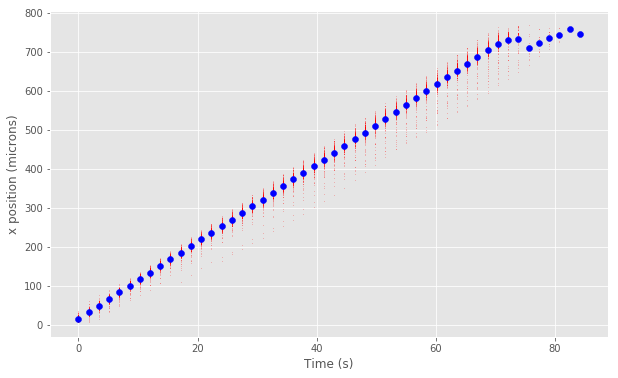

In [38]:
plt.style.use('ggplot')
plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/plot_x_vs_time_' + sample + fig_file_type
plt.savefig(plot_filename, dpi=600)
plt.scatter(collapsed_position['time'], collapsed_position['x'], s=0.1, alpha=0.4, color='red')
plt.scatter(sorted_average_pos['time'][:], sorted_average_pos['x'][:], color='blue')
#plt.xlim(0,250)
#plt.ylim(0,800)
plt.xlabel('Time (s)')
plt.ylabel('x position (microns)')


In [39]:
#sorted_average_pos['expected_position'] = sorted_average_pos['time']*true_particle_velocity + np.min(sorted_average_pos['x'])
sorted_average_pos['expected_position'] = sorted_average_pos['time']*sample_velocity + np.min(sorted_average_pos['x'])

To measure the average displacement of droplets, we compare the actual average position of droplets vs. the expected position of droplets (because we know the imposed velocity). The difference between both gives the average displacement of the droplets.

In the plot below, the displacement is initially 0 (droplets are not affected by the interface yet). It then gradually increases to a plateau value, which correspons to the average displacement of the droplets. The last points of the plot corresponds to the few trajectories that are anormally long. For some reason, in each experiments, a few droplets (2-3) stay stuck at the interface for a very long time. They are thus displaced by large distance. This last part of the plot is thus not statistically significant because it corresponds to only a few trajectories (while we analyse several hundreds trajectories).

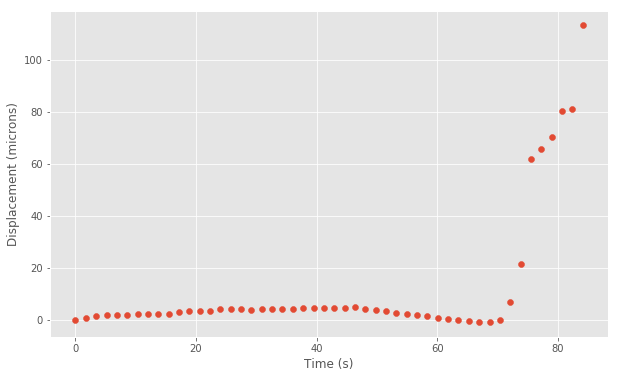

In [40]:
plt.scatter(sorted_average_pos['time'], sorted_average_pos['expected_position']-sorted_average_pos['x'])
plt.xlabel('Time (s)')
plt.ylabel('Displacement (microns)')
#plt.xlim(0,250)
#plt.ylim(-2,20)
plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/plot_displacement_' + sample + fig_file_type
plt.savefig(plot_filename, dpi=600)

## Measure the delay from the average position

To measure the delay (the time during which droplets interact with the front), we use the same approach than for the displacement.

In [41]:
#sorted_average_pos['delay'] = sorted_average_pos['time'] - (sorted_average_pos['x'] - np.min(sorted_average_pos['x']))/true_particle_velocity 
sorted_average_pos['delay'] = sorted_average_pos['time'] - (sorted_average_pos['x'] - np.min(sorted_average_pos['x']))/sample_velocity 

Text(0.5,0,'Time (s)')

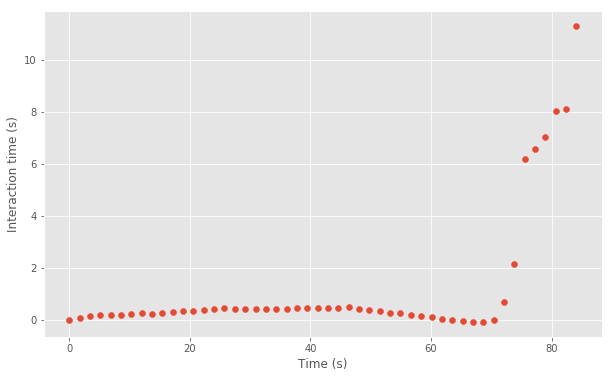

In [42]:
plt.scatter(sorted_average_pos['time'][:], sorted_average_pos['delay'][:])
#plt.ylim(-2,10)
#plt.xlim(0,250)
plt.ylabel('Interaction time (s)')
plt.xlabel('Time (s)')

To get the average interaction time, we average the values on the plateau. You should thus adapt the indexes of the plateau for each sequence, because the plateau are not excatly at the same position for all the sequences.

In [73]:
actual_delay = np.max(sorted_average_pos['delay'][10:20])- np.mean(sorted_average_pos['delay'][10:20])
print (actual_delay)

0.0


In [44]:
sorted_average_pos_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/sorted_average_pos_' + sample + '.csv'

sorted_average_pos.to_csv(sorted_average_pos_filename)

## Compute the velocity using the relative time

In [45]:
# create an empty dataframe to store results

average_pos = pd.DataFrame(columns=['relative_time','x', 'y', 'stdx', 'stdy','expected_position', 'delay']) 

for item in set(collapsed_position.relative_time):
    sub = collapsed_position[collapsed_position.relative_time==item]
    mean_x = np.mean(sub.x_abs)
    mean_y = np.mean(sub.y)
    std_x = np.std(sub.x_abs)
    std_y = np.std(sub.y)
    

    average_pos = average_pos.append([{'relative_time': item,
                                       'x':mean_x,
                                       'y':mean_y,
                                       'stdx':std_x,
                                       'stdy':std_y,
                                       'expected_position':0,
                                       'delay':0}])



In [46]:
sorted_average_pos = average_pos.sort_values('relative_time')

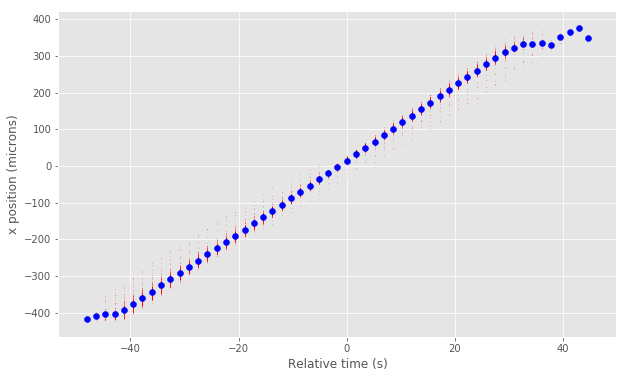

In [48]:
#plt.style.use('ggplot')
plt.scatter(collapsed_position['relative_time'], collapsed_position['x_abs'], s=0.1, alpha=0.4, color='red')
plt.scatter(sorted_average_pos['relative_time'][:], sorted_average_pos['x'][:], color='blue')
#plt.xlim(-140,0)
#plt.ylim(0,700)
plt.xlabel('Relative time (s)')
plt.ylabel('x position (microns)')
plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/plot_x_vs_time_' + sample + fig_file_type
plt.savefig(plot_filename, dpi=600)

In [49]:
averaged_velocity = sample_velocity - np.diff(sorted_average_pos['x'])/spf
#averaged_velocity = true_particle_velocity - np.diff(sorted_average_pos['x'])/spf

Text(0,0.5,'Velocity (microns/s)')

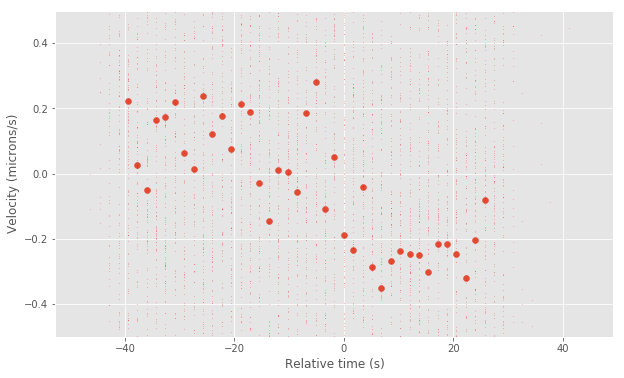

In [61]:
plt.scatter(sorted_average_pos['relative_time'][:-1], averaged_velocity)
plt.scatter(collapsed_position['relative_time'], collapsed_position['x_velocity'], s=0.1, alpha=0.4, color='red')

#plt.xlim(-100, 100)
plt.ylim(-0.5,0.5)
plt.xlabel('Relative time (s)')
plt.ylabel('Velocity (microns/s)')

## Combine the results in a single dataframe and save the data

In [62]:
# convert array to dataframe
intermediate_df = pd.DataFrame(averaged_velocity)

In [63]:
dff = pd.DataFrame(sorted_average_pos['relative_time'][:-1])
dff = dff.reset_index(drop=True) # reset the index
averaged_velocity_df = pd.concat([intermediate_df,dff], axis=1) # combine the two dataframes
averaged_velocity_df = averaged_velocity_df.rename(columns = {0:'velocity'})

In [64]:
sorted_average_pos_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/sorted_average_pos_rel_time' + sample + '.csv'
averaged_velocity_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/sorted_average_velocity_rel_time' + sample + '.csv'

sorted_average_pos.to_csv(sorted_average_pos_filename)
averaged_velocity_df.to_csv(averaged_velocity_filename)

## Compute the displacement by integrating the velocity over time
This is another method to compute the average droplet displacement. We integrate the average droplet velocity vs time. The results of the two methods are similar.

In [65]:
selection = averaged_velocity[10:-12]

In [66]:
displacement = 0

for item in selection:
    displacement = displacement + item*spf

print (displacement)

-3.2383532536676056


## Function to measure the average velocity

In [63]:
def compute_average(data):
    # Function to compute the average value (by intervals) in a serie
    # 100 intervals of 10 pixels
    
    average_velocity = pd.DataFrame(columns=['position','mean_velocity', 'std']) # create an empty dataframe to store results
    for i in range(100):
        sub = collapsed_position[(collapsed_position.x_abs>(-500+i*10-5)) & (collapsed_position.x_abs<(-500+i*10+5))]
        mean_vel = np.mean(sub.x_velocity)
        std_dev_velocity = np.std(sub.x_velocity)/np.sqrt(len(sub)-1)
        average_velocity = average_velocity.append([{'position': -500+i*10,
                                                 'mean_velocity':mean_vel, 
                                                 'std':std_dev_velocity}])
    return average_velocity

## Average velocity vs. distance to interface

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


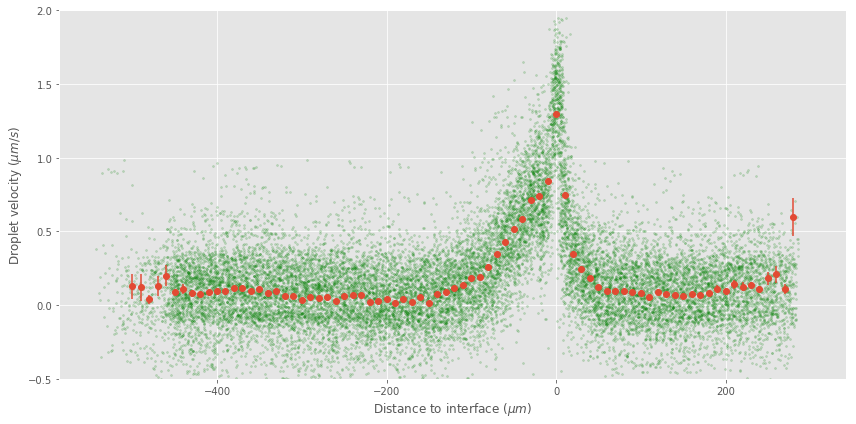

In [67]:
average_velocity = compute_average(collapsed_position)
plt.figure(1, figsize=(12, 6))
plt.errorbar(average_velocity['position'], average_velocity['mean_velocity'],yerr=average_velocity['std'],fmt='o')
plt.scatter(collapsed_position['x_abs'], collapsed_position['x_velocity'], s=4, alpha=0.2, color='green')

#plt.xlim(-300,200)
plt.ylim(-0.5,2)
plt.xlabel(r'Distance to interface ($\mu m$)')
plt.ylabel(r'Droplet velocity ($\mu m/s$)')
fig_file_type = '.pdf'
plt.tight_layout()
velocity_plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/plot_xvelocity_vs_distance_to_interface_' + sample + fig_file_type
velocity_plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/plot_xvelocity_vs_distance_to_interface_' + sample + ".png"

plt.savefig(velocity_plot_filename, dpi=600)

### Verify that both methods to measure velocity are consistent

In [ ]:
plt.scatter(sorted_average_pos['x'][:-1], averaged_velocity)
plt.errorbar(average_velocity['position'], average_velocity['mean_velocity'],yerr=average_velocity['std'],fmt='o')
plt.ylim(-.4,1.2)
#plt.xlim(-300,200)
plt.xlabel('Distance to interface (microns)')
plt.ylabel('Object velocity')
velocity_plot_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/combined_velocity_plot' + sample + fig_file_type
plt.savefig(velocity_plot_filename, dpi=600)

## Save the results to CSV files for later use

In [ ]:
velocity_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/average_velocity_' + sample + '.csv'
position_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/collapsed_position_' + sample + '.csv'

average_velocity.to_csv(velocity_filename)
collapsed_position.to_csv(position_filename)

## Compute the displacement of the objects by integrating their velocity with time

In [ ]:
displacement_array = []

for item in set(collapsed_position.track_id):
    sub = collapsed_position[collapsed_position.track_id==item]
    starting_x = sub.x_abs.iloc[0] # lowest x value (first x position when particle enters the frame)
    if (starting_x < -300) and (np.max(sub.x_abs)>100):
        displacement = np.sum(sub.x_velocity)*spf
        particle_diameter = np.mean(sub.diameter)
        displacement_array.append(displacement)

displacement_filename = 'Z:/PhD/Experiments & Results/Data Complete/results/displacement_' + sample + '.csv'

np.savetxt(displacement_filename, displacement_array, delimiter=",")
np.mean(displacement_array)

In [ ]:
import os
os.system('say "your script is finished"')

In [ ]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py\n",
# you need to run the line above only once
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas, trackpy, skimage, pims